# Notebook 2

### In this notebook we:

    1. Load PCA projections of all short MDs
    2. Load previously constructed milestones (disk positions and unit vectors in PC space)
    3. Label all points based on which microstate they belong

In [1]:
# import all libraries
import sys; import os
import pytraj as pt
from sklearn.decomposition import PCA
import numpy as np
import scipy

# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import art3d

# bkit
from BKit.Utils import SplitEvenOdd, PlotSelected, pathpatch_2d_to_3d
from BKit.ConstructMilestones3D import SortFrames, rotation_matrix
from BKit.SmoothPath import BuildSmoothMeanPath
from BKit.InterpolateCurve import InterpolatePath
from BKit.ConstructMilestones3D import ConstructMilestones3D

###  Set model parameters

In [2]:
ml_length = 0.8    # distance between milestones
dr = 2.0           # milestone radius (disk radius)
dim = 3            # pc dimention    
yz_pad = 8
dz = 0.2

### Set  path & load previoulsly saved data

In [3]:
# path
DIR_SAVE = '../output'
complex_name = 'Cyc_asp'

# load
inp = np.load(DIR_SAVE + '/MlPosNorms.npy')
dat = np.load(DIR_SAVE + '/PCA' + '/PCA.npy')
pathAll = inp[:,0:3];  normalsAll = inp[:,3:6]

In [4]:
diskID, midID = SplitEvenOdd(N=pathAll.shape[0])
pathMid = pathAll[midID] # pseudo disks
pathP = pathAll[diskID]    

normalsMid = normalsAll[midID] # pseudo normals
normals = normalsAll[diskID]       

n_cells = normalsMid.shape[0]
n_disks = normals.shape[0]

### Assign distinct label to different microstates

In [5]:
SortF = SortFrames(dat,dr,dz)
datMid, CellIndx = SortF.SortAllPoints(normals, normalsMid, pathP, pathMid, SortMethod='middle')

In [7]:
nf = dat.shape[0] 
n_sel = datMid.shape[0]
print('total frames',nf)
print('Number of selected points', n_sel)
print('Number of Cells ', n_cells)
print('Number of Disks ', n_disks)

total frames 8620000
Number of selected points 2581776
Number of Cells  55
Number of Disks  56


### Randomly select subset for visualization (hard to vis all points)

In [8]:
rand_sel = np.random.randint(0, n_sel, 50000)
dat_sel = datMid[rand_sel,:]

### Visualize microstates

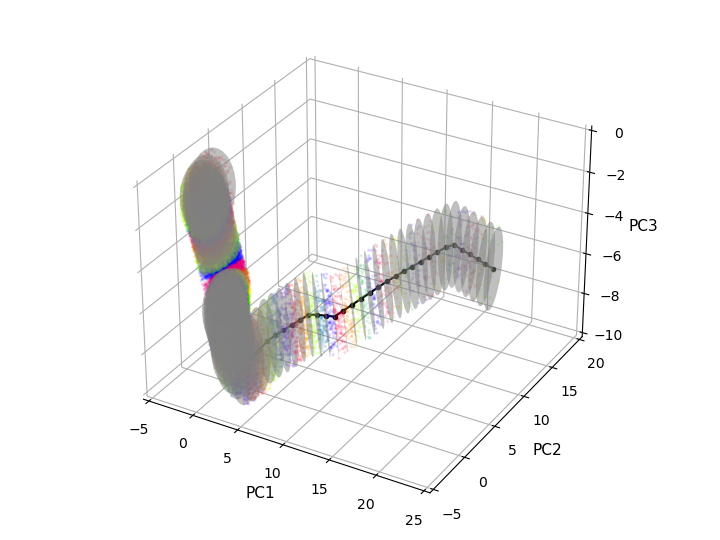

In [9]:
%matplotlib widget
fs = 11
fig = plt.figure(figsize = [7.2, 5.4])
ax = plt.axes(projection='3d')
cmap = 'prism'#'Set1'

#plot path poits
ax.plot3D(pathP[:,0], pathP[:,1], pathP[:,2], c='black', marker='o', markersize=3, alpha=1.)
ax.set_xlabel('PC1', fontsize=fs)
ax.set_ylabel('PC2',fontsize=fs)
ax.set_zlabel('PC3',fontsize=fs)

#plotting disks
for i in range(n_disks):
    c = Circle((0,0), dr, facecolor='grey', alpha=0.5)
    ax.add_patch(c)
    pathpatch_2d_to_3d(c, pathP[i], normal = normals[i])
   
#plot selected points
p = ax.scatter3D(dat_sel[:,0], dat_sel[:,1], dat_sel[:,2], c = dat_sel[:,3],
                 alpha=.10, s = 2., cmap = cmap)
   
x_min, y_min, z_min = pathP.min(axis=0) 
x_max, y_max, z_max = pathP.max(axis=0)
ax.set_xlim3d(x_min, x_max)
ax.set_ylim3d(y_min - yz_pad, y_max + yz_pad)
ax.set_zlim3d(z_min - yz_pad, z_max + yz_pad)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_xlim3d(-5,25); ax.set_ylim3d(-5,20); ax.set_zlim3d(-10,0)
#ax.set_axis_off()
fig.tight_layout()
#plt.savefig(DIR_SAVE + complex_name + 'states.png', dpi=600)
plt.show()    

### Save all labels as one long array

In [ ]:
print("writing outputs to " + DIR_SAVE)
np.save(DIR_SAVE + '/CellIndx.npy', CellIndx)

* Above labels will be used in next step to build transition kernel

## Unbinding path reoptimization 


Unbinding path constructed by a single unbinding trajectory, or the sampling method often may not be an accurate representation of the dissociation path. Thus, we performe reoptimization
using short MDs in a hope to get a better path.


In [11]:
w_size = 50        # rolling ave window size, which is used as reference path
stride = w_size//5 # rolling ave stride, num of frames to skip between windows 
ml_length = .80    # distance between milestones
n_iter = 8000      # number of iterations for ML disk normal optimization
thresh = -0.27     # threshold to remove points (thresh = cos(alpha), thresh=0.0 means angle is 90)

In [18]:
# this constructs 3D path
SReactPath = BuildSmoothMeanPath(dat, w_size=w_size, thresh=thresh, stride=stride)    

# re-optimize previously built path with short MD projections
# can also try larger k-d tree search radius to see how path will change
path_opt = SReactPath.GetPathKD_ReOpt(dat=dat, mean_path=pathAll, rad=4.0, w_size=w_size, stride=stride)

#interpolate paths  
InterPathOpt = InterpolatePath(path_opt, pair_dist = ml_length , dim=dim, kind='linear')

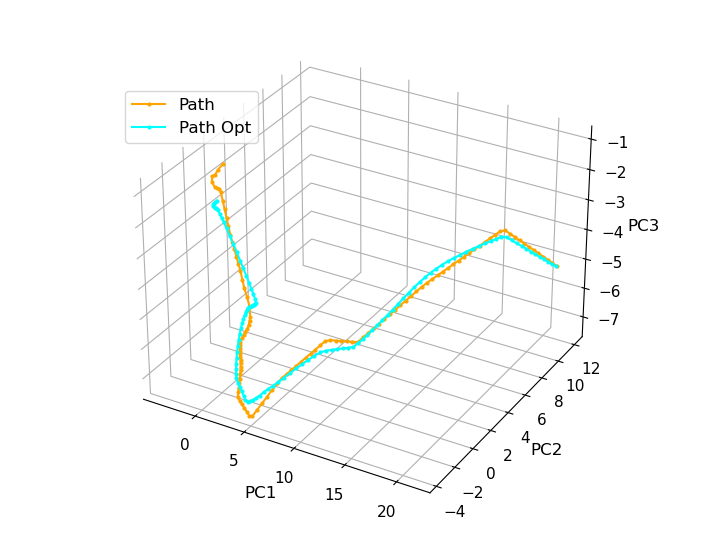

In [19]:
%matplotlib widget
fs = 12
fig = plt.figure(figsize = [7.2, 5.4])
ax = plt.axes(projection='3d')

ax.plot3D(pathAll[:,0], pathAll[:,1], pathAll[:,2], 'orange', marker='o', markersize=2)
ax.plot3D(path_opt[:,0], path_opt[:,1], path_opt[:,2], 'cyan', ls='-', marker='o', markersize=2)
#ax.plot3D(InterPathKD[:,0], InterPathKD[:,1], InterPathKD[:,2], 'black', ls='-', marker='o', markersize=2)

ax.set_xlabel('PC1', fontsize=fs)
ax.set_ylabel('PC2',fontsize=fs)
ax.set_zlabel('PC3',fontsize=fs)
#ax.set_xlim3d(-5,25); ax.set_ylim3d(-5,20); ax.set_zlim3d(-10,0)
plt.legend(["Path", "Path Opt"], loc = [0.04,0.75], fontsize=fs)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.xaxis.set_tick_params(labelsize=fs-1)
ax.yaxis.set_tick_params(labelsize=fs-1)
ax.zaxis.set_tick_params(labelsize=fs-1)
#ax.set_axis_off()

fig.tight_layout()
#plt.savefig(FIG_SAVE + complex_name + '3D_path.png', dpi=600)
plt.show()

Optimized path does look a bit different that the original. It is interesting to check how it will affect the free energy. One needs to rebuild disks (milestones) the same way as shown in notebook1. Then regenerate state labels as shown earlier. 